In [8]:
from numpy.linalg import qr, svd

from scipy.linalg import hadamard, subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

import os
import sys
parent_dir = os.path.dirname(os.getcwd())  # Get the parent directory
sys.path.append(parent_dir)
from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

import wandb

In [6]:
X = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy").swapaxes(1,2) 
X, _ = pre_processing(X, soft_normalize='max', center=False)
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)                
A = A.reshape(N,-1)    

c = 30
d = 3

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 4.421685695648193, S_ratio: 0.07845126837491989
Iteration 10, S: 13.521013259887695, S_ratio: 0.20944096148014069
Iteration 20, S: 22.30731201171875, S_ratio: 0.2583797872066498
Iteration 30, S: 70.14253234863281, S_ratio: 0.32348912954330444
Iteration 40, S: 83.79808807373047, S_ratio: 0.3335394263267517
Iteration 50, S: 103.43062591552734, S_ratio: 0.36458441615104675
Iteration 60, S: 113.81902313232422, S_ratio: 0.3844524025917053
Iteration 70, S: 127.26348114013672, S_ratio: 0.3764724135398865
Iteration 80, S: 171.8563995361328, S_ratio: 0.39803633093833923
Iteration 90, S: 174.3577880859375, S_ratio: 0.3985934853553772
Iteration 100, S: 140.837890625, S_ratio: 0.432319700717926
Iteration 110, S: 237.26119995117188, S_ratio: 0.429621160030365
Iteration 120, S: 245.09844970703125, S_ratio: 0.4057985544204712
Iteration 130, S: 266.9781494140625, S_ratio: 0.41417238116264343
Iteration 140, S: 302.8177795410156, S_ratio: 0.41560661792755127
Iteration 150, S: 330.0074157

Text(0.5, 0.92, 's = 0.35576677322387695')

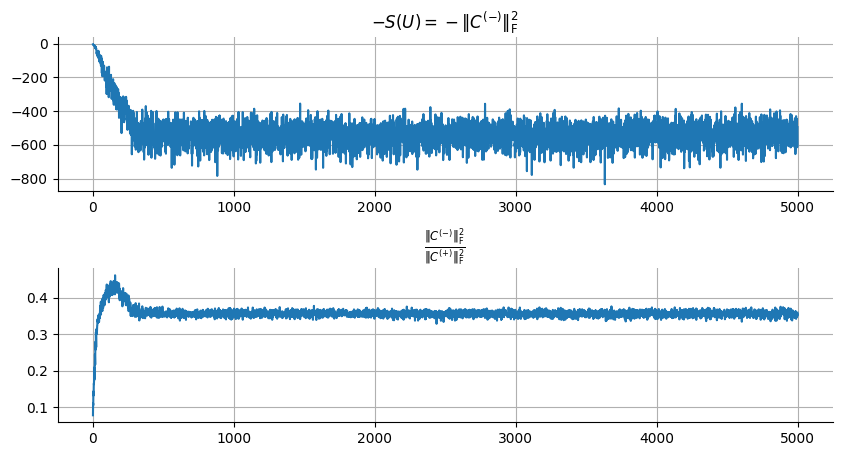

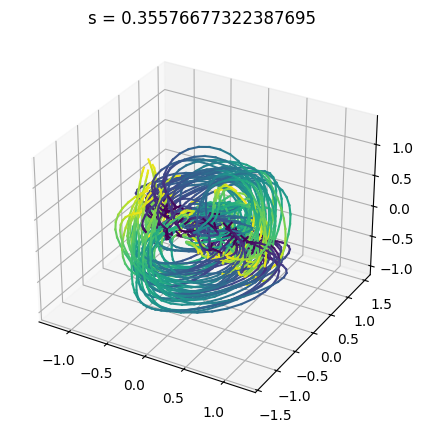

In [4]:
kernel_function = K_X_Y_squared_exponential

wandb.init(project="SCA-project-MC_Maze", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=5000, learning_rate=1e-3, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio)

_, u, l2 = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H  = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = K_X_Y_squared_exponential(u, X_reshaped, l2=l2).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

plot_3D(Y[:,:,:])
plt.title(f's = {compute_S_all_pairs(Y)}')

In [ ]:
test = np.load('/Users/ariellerosinski/My Drive/params_4d_gaussian.npy', allow_pickle=True).tolist()

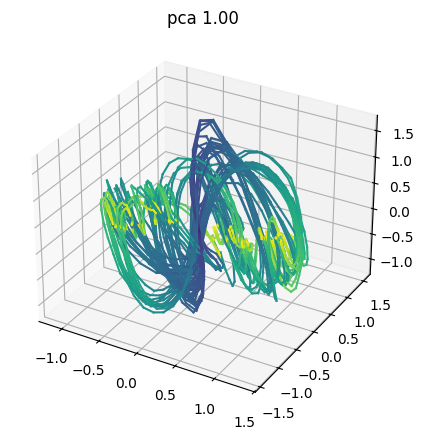

In [14]:
X_pca = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/aug_behaviour.npy")
K, N, T = X_pca.shape
X_pca, _ = pre_processing(X_pca, soft_normalize='max', pca=False)
X_reshaped = np.concatenate(X_pca.swapaxes(1,2))

num_pcs = 6
pca = PCA(num_pcs)
Y_pca = pca.fit(X_reshaped).transform(X_reshaped) #train, test 
PCs = pca.components_
Y_pca = Y_pca.reshape(K, T, num_pcs).swapaxes(1,2) #split
pca_variance_captured = pca.explained_variance_ratio_

plot_3D(Y_pca)
plt.title(f"pca {var_explained(X_pca, PCs.T):.2f}")
np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/Y_pca_{num_pcs}d_behaviour', Y_pca)